In [11]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1
samples = [rng() for _ in range(1000)]

## Serial test

Idea: break the sequence $x_1, x_2, x_3, ..., x_{2n}$ into consecutive series of length $2$: $(x_1, x_2), (x_3, x_4), ..., (x_{2n-1}, x_{2n})$ and look at each element as a random and independent point in $2D$ space. Next, apply chi-square. Similarly, one can construct series of length $3, 4$, etc.

### Problem 1
Implement serial test and apply to a `samples`

In [12]:
def serial_test(samples):
    pairs = np.array(samples).reshape(-1, 2)
    k = 5
    f_obs = np.histogram2d(pairs[:,0], pairs[:,1], bins=(k,k))[0]
    f_exp = np.full((k, k), len(pairs) // (k**2) , dtype='float64')
    result = stats.chisquare(f_obs.ravel(), f_exp.ravel())
    print(f'Statistic: {result.statistic}, p_value: {result.pvalue}')
    return result

serial_test(samples)

Statistic: 20.2, p_value: 0.6853475385372763


Power_divergenceResult(statistic=20.2, pvalue=0.6853475385372763)

### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

In [13]:
from itertools import permutations

def permutation_test(samples, d):
    if (len(samples) % d != 0):
        remainder = len(samples) % d
        samples = samples[:-remainder]

    all_permutations = list(permutations(range(d)))
    perm_counts = {permutation: 0 for permutation in all_permutations}

    series = np.array(samples).reshape(-1, d)

    for sequence in series:
        sorted_indices = np.argsort(sequence)
        permutation = tuple(sorted_indices)
        perm_counts[permutation] += 1
    
    f_obs = np.array(list(perm_counts.values()))
    f_exp = np.full(len(f_obs), len(series)/ len(all_permutations))
    result = stats.chisquare(f_obs, f_exp)
    print(f'Statistic: {result.statistic}, p_value: {result.pvalue}')
    
    return result

permutation_test(samples, 3)

Statistic: 4.8558558558558556, p_value: 0.4337239950364655


Power_divergenceResult(statistic=4.8558558558558556, pvalue=0.4337239950364655)

In [14]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [15]:
def triplets_test(data, grid_size=10):
    triplets = np.array(data).reshape(-1, 3)

    bins = np.linspace(0, 1, grid_size + 1)

    f_obs = np.histogramdd(triplets, bins=[bins, bins, bins])[0].ravel()
    f_exp = np.full_like(f_obs, (len(data) // 3) / (grid_size ** 3))

    result = stats.chisquare(f_obs, f_exp)
    print(f'Statistic: {result.statistic}, p_value: {result.pvalue}')

    return result

good_samples = [rng() for _ in range(300000)]
bad_samples = [rng_bad() for _ in range(300000)]

triplets_test(good_samples, grid_size=10)
triplets_test(bad_samples, grid_size=10)

Statistic: 965.3799999999999, p_value: 0.7721033785083211
Statistic: 1593.26, p_value: 4.9047281869171085e-30


Power_divergenceResult(statistic=1593.26, pvalue=4.9047281869171085e-30)

# Generating a sample from a given distribution

Suppose we have a random number generator from the segment [0, 1] (use the `np.random.rand()` function for this). How to get a sample from another distribution $F$?

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

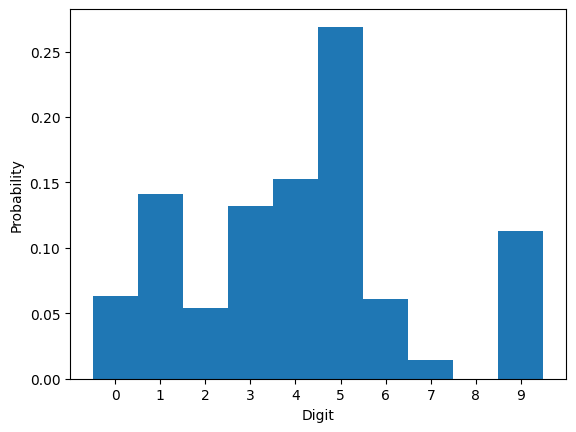

In [16]:
weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
digits = np.arange(10) 

weights /= weights.sum()

sorted_indices = np.argsort(weights)[::-1]
sorted_weights = weights[sorted_indices]
sorted_digits = digits[sorted_indices]

cumsum = np.cumsum(sorted_weights)
n_samples=1000

samples = []
for _ in range(n_samples):
    u = np.random.rand()
    idx = np.searchsorted(cumsum, u)
    samples.append(sorted_digits[idx])

plt.hist(samples, bins=np.arange(11) - 0.5, density=True)
plt.xticks(digits)
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.show()

## Inverse transform method

The following proposition is the idea behind the *inverse transform* method:

If $\xi$ has a uniform distribution in $[0,1]$, then $F^{-1}(\xi)$ is distributed according to the law of $F$. (For which $F$ is this true?)

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

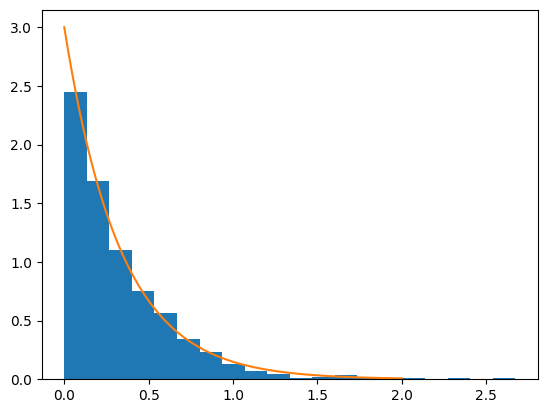

In [17]:
from scipy.stats import expon

def simulate_exponential(lamda):
    def f():
        return -np.log(1-rng())/lamda
    
    sample = np.array([f() for _ in range(1000)])  
    x = np.linspace(0, 2, 1000)

    plt.hist(sample, 20, density=True)
    plt.plot(x, expon.pdf(x, scale = 1/lamda))
    plt.show()

simulate_exponential(3)

### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

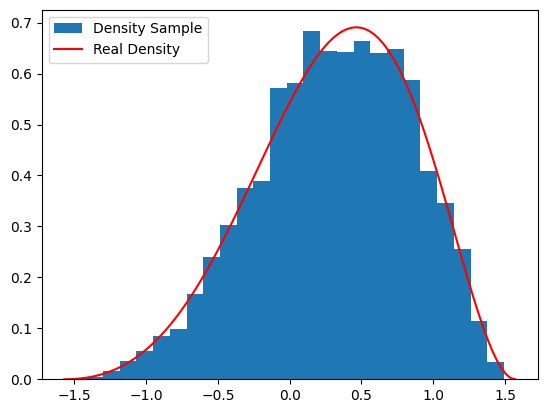

In [18]:
def accept_reject(n_samples):
    def clamp_to_coords(x_0=-np.pi/2, x_1=np.pi/2, y_0=0, y_1=1.2):
        return [rng()*(x_1 - x_0) + x_0, rng()*(y_1 - y_0) + y_0]
    
    x = np.linspace(-np.pi/2, np.pi/2, 100)
    density = np.exp(x) * np.cos(x) ** 2
    
    square_sample = np.array([ clamp_to_coords() for _ in range(n_samples) ])
    density_sample = np.array([ [x, y] for x, y in square_sample if np.exp(x) * np.cos(x) ** 2 > y ])
    plt.hist(density_sample[:,0].ravel(), bins=25, density=True, label='Density Sample') 
    plt.plot(x,density/np.trapz(density, x), color='r', label='Real Density')
    plt.legend()
    plt.show()

accept_reject(10000)

## Coordinate transformation method

The accept-reject method may in some cases be inefficient and require too many sample points. An alternative is to try to find a coordinate transformation that converts a simple area (from which it is easy to sample, for example, a unit square) into the required area, but preserves the area ratio (why?).

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

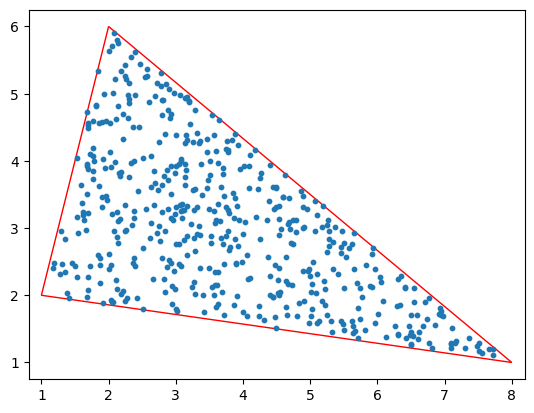

In [19]:
from matplotlib.patches import Polygon

A = np.array([1, 2])
B = np.array([2, 6])
C = np.array([8, 1])

def sample_triangle(n_samples=500):
    u = np.array([rng() for _ in range(n_samples)])
    v = np.array([rng() for _ in range(n_samples)])

    mask = u + v > 1 #if we don't do this we will get mirrored side of the triangle as well
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    w = 1 - u - v

    points = u[:, None] * A + v[:, None] * B + w[:, None] * C
    return points

points = sample_triangle(n_samples=500)

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True, facecolor='none', edgecolor='r')
plt.gca().add_patch(polygon)
plt.scatter(points[:, 0], points[:, 1], s=10)
plt.axis('equal')
plt.show()

### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

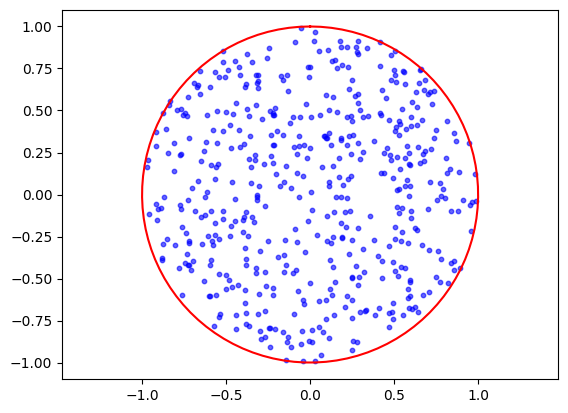

In [ ]:
def sample_unit_circle(n_samples=500): #we will use polar coordinates
    r = np.sqrt(np.array([rng() for _ in range(n_samples)]))  
    theta = np.array([rng() * 2 * np.pi for _ in range(n_samples)])
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))

points = sample_unit_circle(n_samples=500)
t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t), color='r')
plt.scatter(points[:, 0], points[:, 1], s=10, c='blue', alpha=0.6)
plt.axis('equal')
plt.show()